In [1]:
import Global_Functions as gf
import Surrogate_Modell as sm
import Neuronal_Networks as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action = 'once')
import time
timestr = time.strftime("%Y-%m-%d_%H-%M_")

import warnings
warnings.filterwarnings("once")

In [2]:
OPEN_FOLDER = '../Data/Preped_Data/'

In [3]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [4]:
train = "4"
val = "21"

ex_train = ex_4
ex_val = ex_21

In [5]:
NEUR = 128
EPOCH = 100
LAG = 60

In [6]:
image_path = "../Images/"
image_subfolder = image_path + "Hybrid Model/"
specs = "training_{0} val_{1} {2}_neurons__{3}_epochs__lag_{4}" 
image_folder = image_subfolder + timestr + specs.format(train, val, NEUR, EPOCH, LAG) + "/"

gf.check_folder(image_path)
gf.check_folder(image_subfolder)
gf.check_folder(image_folder)

Folder already exists.
Folder already exists.
Creation of directory ../Images/Hybrid Model/2021-03-19_09-32_training_4 val_21 128_neurons__100_epochs__lag_60/ successful.


In [7]:
ex_1 = gf.open_CSV_file('experiment_1_short.csv', OPEN_FOLDER)
ex_4 = gf.open_CSV_file('experiment_4_short.csv', OPEN_FOLDER)
ex_9 = gf.open_CSV_file('experiment_9_short.csv', OPEN_FOLDER)
ex_20 = gf.open_CSV_file('experiment_20_short.csv', OPEN_FOLDER)
ex_21 = gf.open_CSV_file('experiment_21_short.csv', OPEN_FOLDER)
ex_22 = gf.open_CSV_file('experiment_22_short.csv', OPEN_FOLDER)
ex_23 = gf.open_CSV_file('experiment_23_short.csv', OPEN_FOLDER)
ex_24 = gf.open_CSV_file('experiment_24_short.csv', OPEN_FOLDER)

In [8]:
def linear_func(x, a, b):
    return a*x + b

def quadr_func(x, p1, p2, p3):
    return p1 * x**2 + p2*x + p3

def exp_func(x, k, tau):
    return -k* np.exp((-1/tau)*x) +k

In [9]:
def load_meta_modell(exp_train):
    func_k = linear_func
    func_tau = quadr_func
    
    start = time.time()

    time_splits = sm.get_time_splits(exp_train)
    exp_train['el_approx'], params_el, duration_el = sm.all_approximations(exp_train['time'], exp_train['input_voltage'], exp_train['el_power'], time_splits)
    df_params = sm.create_dataframe_for_parameters(params_el)
    
    prm_k_el, prm_tau_el = sm.parameter_modelling(df_params, func_k, func_tau, '_electric', image_folder)
    
    duration = time.time() - start
    
    return prm_k_el, prm_tau_el, duration

In [10]:
def train_model(experiment_train, experiment_validation, lag_input = 1, lag_output = 1, batch_size = 1, nmb_epochs = 20, neurons = 64):
    prm_k_el_train, prm_tau_el_train, duration_meta_build = load_meta_modell(experiment_train)
    
    predictions_train, duration_meta_predict = sm.predict_other_experiment(prm_k_el_train, prm_tau_el_train, experiment_train, 'el_power')
    predictions_val, _ = sm.predict_other_experiment(prm_k_el_train, prm_tau_el_train, experiment_validation, 'el_power')
    experiment_train['theor_predictions'] = predictions_train
    experiment_validation['theor_predictions'] = predictions_val
    
    scaler_train, X_train, y_train = nn.prepare_data(experiment_train, lag_input = lag_input, all_lags = False, hybrid = True)
    scaler_val, X_val, y_val = nn.prepare_data(experiment_validation, lag_input = lag_input, all_lags = False, hybrid = True)
    
    model = nn.fit_lstm(X_train, y_train, X_val, y_val, 1, nb_epochs = nmb_epochs, neurons = neurons)
    
    model = [model, prm_k_el_train, prm_tau_el_train]
    return model, scaler_train, X_train, y_train, scaler_val, X_val, y_val    

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Surrogate_Modell.py:17: RuntimeWarning: overflow encountered in exp
  return -k* np.exp((-1/tau)*x) +k
C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Neuronal_Networks.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['theor_pred'] = theor_preds_scaled
C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Neuronal_Networks.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['theor_pred'] = theor_preds_scaled


9795/9795 [==============================] - 20s 2ms/step - loss: 0.0058 - val_loss: 0.5537


9795/9795 [==============================] - 18s 2ms/step - loss: 0.0117 - val_loss: 0.5035


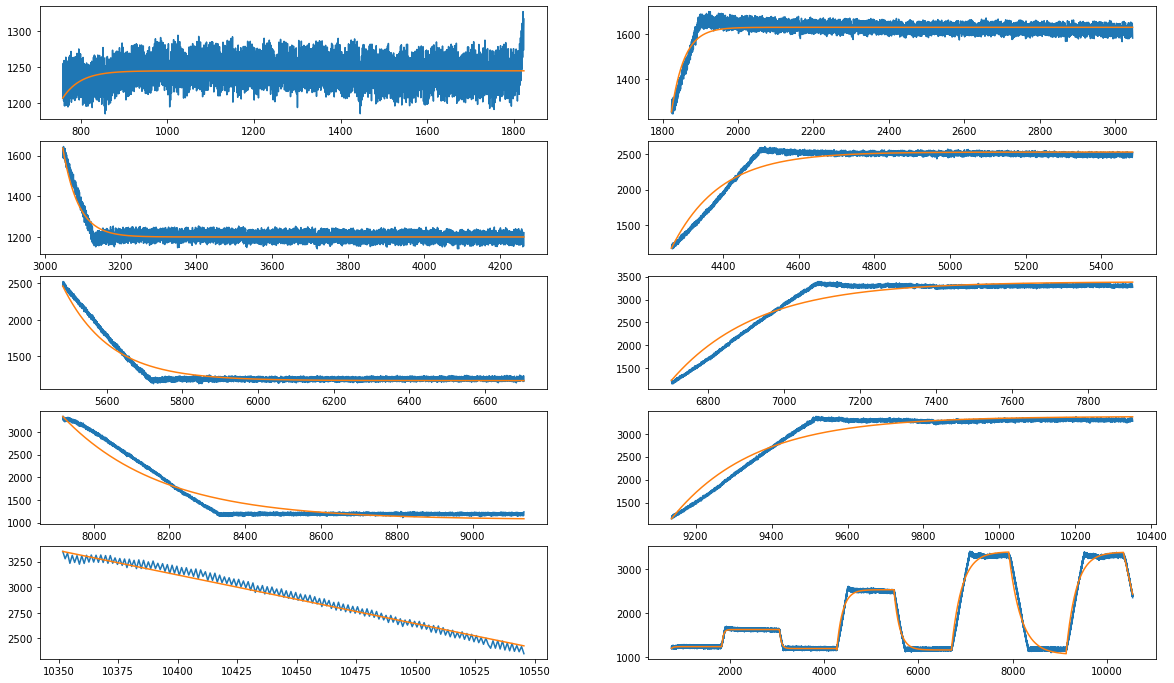

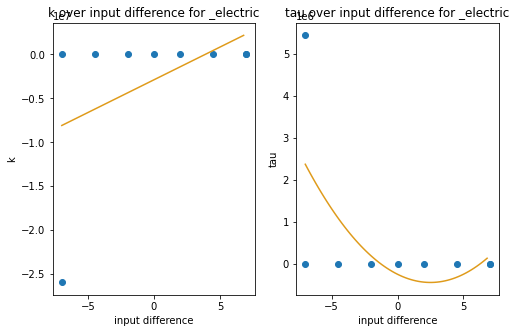

In [11]:
model, scaler, X_train, y_train, _, X_val, y_val = train_model(ex_train, ex_val, lag_input=LAG, lag_output = 1, batch_size=1, neurons=NEUR, nmb_epochs=EPOCH)

In [12]:
def predictions(experiment, model, batch_size = 1, specs = ""):
    k = model[1]
    tau = model[2]
    model = model[0]
    
    predictions, duration_meta_predict = sm.predict_other_experiment(k, tau, experiment, 'el_power')
    experiment['theor_predictions'] = predictions
    scaler, X, y = nn.prepare_data(experiment, lag_input = LAG, all_lags = False, hybrid = True)
    
    preds_scaled = model.predict(X, batch_size = batch_size)
    preds = scaler[1].inverse_transform(preds_scaled)
    
    fig = plt.figure(figsize = (15,10))
    plt.plot(experiment['el_power'], color = gf.get_color("grey"), label = "True")
    plt.plot(preds, color = gf.get_color("green"), label = "Predictions")
    plt.ylabel('Electric power in [W]')
    plt.xlabel('Time')
    plt.legend()
    plt.title('Comparison predictions to true values' + specs, fontsize = 14)
    fig.tight_layout()
    plt.show()
    fig.savefig(image_folder + specs + "predictions.png")
    fig.savefig(image_folder + specs + "predictions.svg")
    
    return scaler, X, y, preds_scaled, preds

In [13]:
scaler_1, X_1, y_1, preds_scaled_1, preds_1 = predictions(ex_1, model, specs = " on ex_1 with model trained on " + train)

C:\Users\FlorianLeiser\Documents\Masterarbeit\Code\Neuronal_Networks.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['theor_pred'] = theor_preds_scaled


AttributeError: 'tuple' object has no attribute 'predict'

In [ ]:
scaler_4, X_4, y_4, preds_scaled_4, preds_4 = predictions(ex_4, model, specs = " on ex_4 with model trained on " + train)

In [ ]:
scaler_9, X_9, y_9, preds_scaled_9, preds_9 = predictions(ex_9, model, specs = " on ex_9 with model trained on " + train)

In [ ]:
scaler_20, X_20, y_20, preds_scaled_20, preds_20 = predictions(ex_20, model, specs = " on ex_20 with model trained on " + train)

In [ ]:
scaler_21, X_21, y_21, preds_scaled_21, preds_21 = predictions(ex_21, model, specs = " on ex_21 with model trained on " + train)

In [ ]:
scaler_22, X_22, y_22, preds_scaled_22, preds_22 = predictions(ex_22, model, specs = " on ex_22 with model trained on " + train)

In [ ]:
scaler_23, X_23, y_23, preds_scaled_23, preds_23 = predictions(ex_23, model, specs = " on ex_23 with model trained on " + train)

In [ ]:
scaler_24, X_24, y_24, preds_scaled_24, preds_24 = predictions(ex_24, model, specs = " on ex_24 with model trained on " + train)